In [134]:
import os 
import timm
import torch
import torch
import torch.nn as nn
import requests
import timm
import math
from PIL import Image
from torchvision import transforms
import pytorch_lightning as pl
import matplotlib.pyplot as plt

In [2]:
from multissl.models import FastSiam

In [80]:
checkpoint = "../checkpoints_swin/last.ckpt"
state_dict= torch.load(checkpoint)["state_dict"]
state_dict = clean_state_dict(state_dict, prefix_to_strip = "backbone.", skip_if_contains=["prediction_head", "projection_head"])

In [126]:


    
sample_url = "../../msdata/data/chipped_224/3M_SUNCAL_3m_uk_vineyard_east_july_DJI_20240714105409_0078_MS_300_2304.tif"
x, img = load_tiff_tensor(sample_url, image_size=224)  # shape [1,4,224,224]


100%|███████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 11066.77it/s]


In [88]:
with torch.no_grad():
    feats = vit.forward_features(x)
    head = vit.forward_head(feats)
    out = vit(x)
    output, intermediates = vit.forward_intermediates(x)


In [94]:
import torch.nn.functional as F

In [127]:
#forward pass and extract the cls and attn stuff
y = vit(x)

attn_map = vit.blocks[-1].attn.attn_map.mean(dim=1).squeeze(0).detach()
cls_weight = vit.blocks[-1].attn.cls_attn_map.max(dim=1).values.view(14, 14).detach()

img_resized = x.squeeze(0).permute(1, 2, 0) * 0.5 + 0.5
cls_resized = F.interpolate(cls_weight.view(1, 1, 14, 14), (224, 224), mode='bilinear').view(224, 224, 1)

In [129]:
# Extract attention maps and class scores from the model's blocks
from tqdm import tqdm
# Extract attention maps and class scores from the model's blocks
attn_maps = []
cls_weights = []
for block in tqdm(vit.blocks):
    attn_maps.append(block.attn.attn_map.max(dim=1).values.squeeze(0).detach())
    cls_weights.append(block.attn.cls_attn_map.mean(dim=1).view(14, 14).detach())

# Combine class scores of all blocks
cls_weight_combined = torch.prod(torch.stack(cls_weights), dim=0)
attn_maps_prod = torch.prod(torch.stack(attn_maps), dim=0)

100%|█████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 657.42it/s]


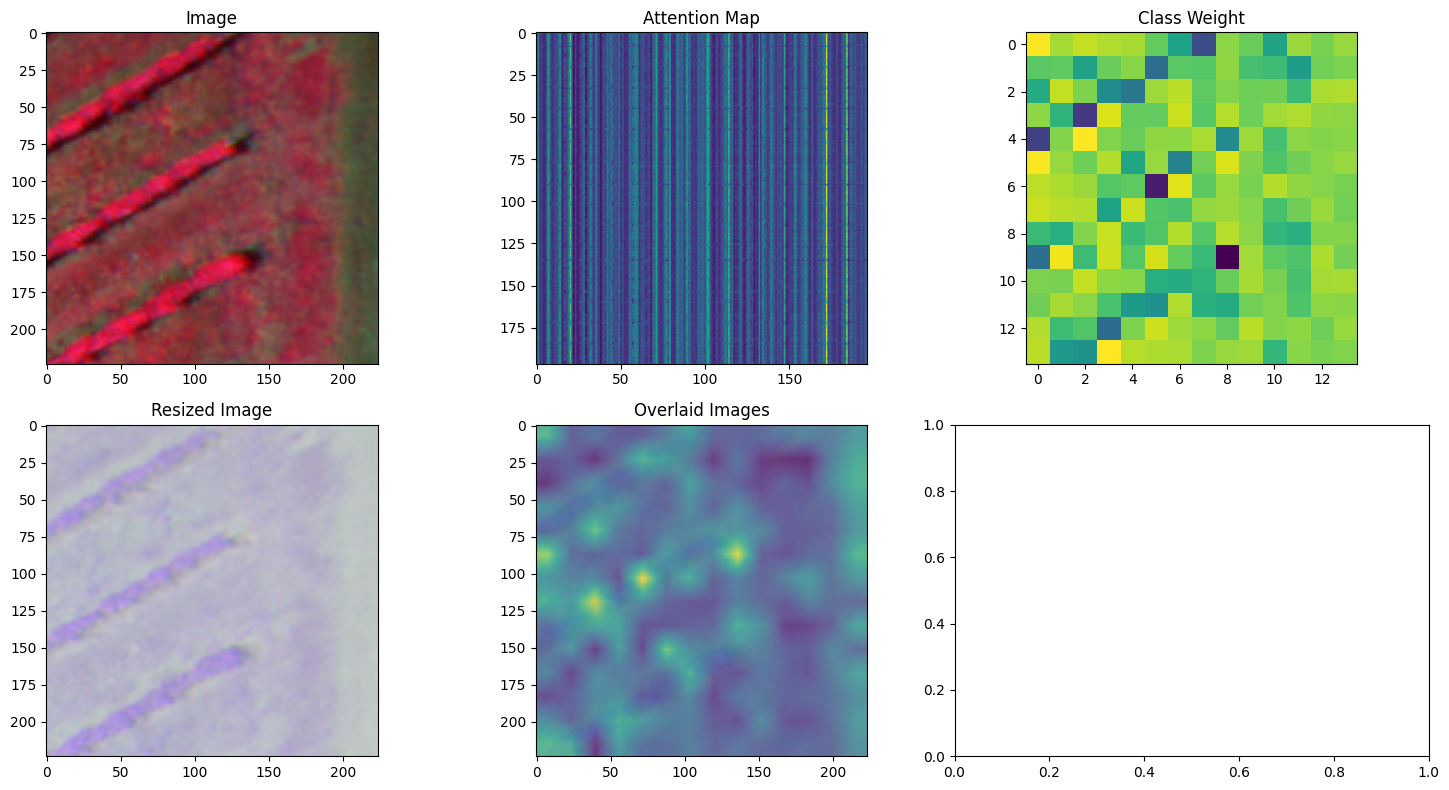

In [157]:
# Ensure tensors are on the CPU
attn_map_cpu = attn_map.cpu()
cls_weight_cpu = cls_weight.cpu()
cls_resized_cpu = cls_resized.cpu()

# Call the plot_set function with CPU tensors
plot_set(img[:,:,[3,1,0]], attn_map_cpu, cls_weight_cpu, img_resized, cls_resized_cpu)

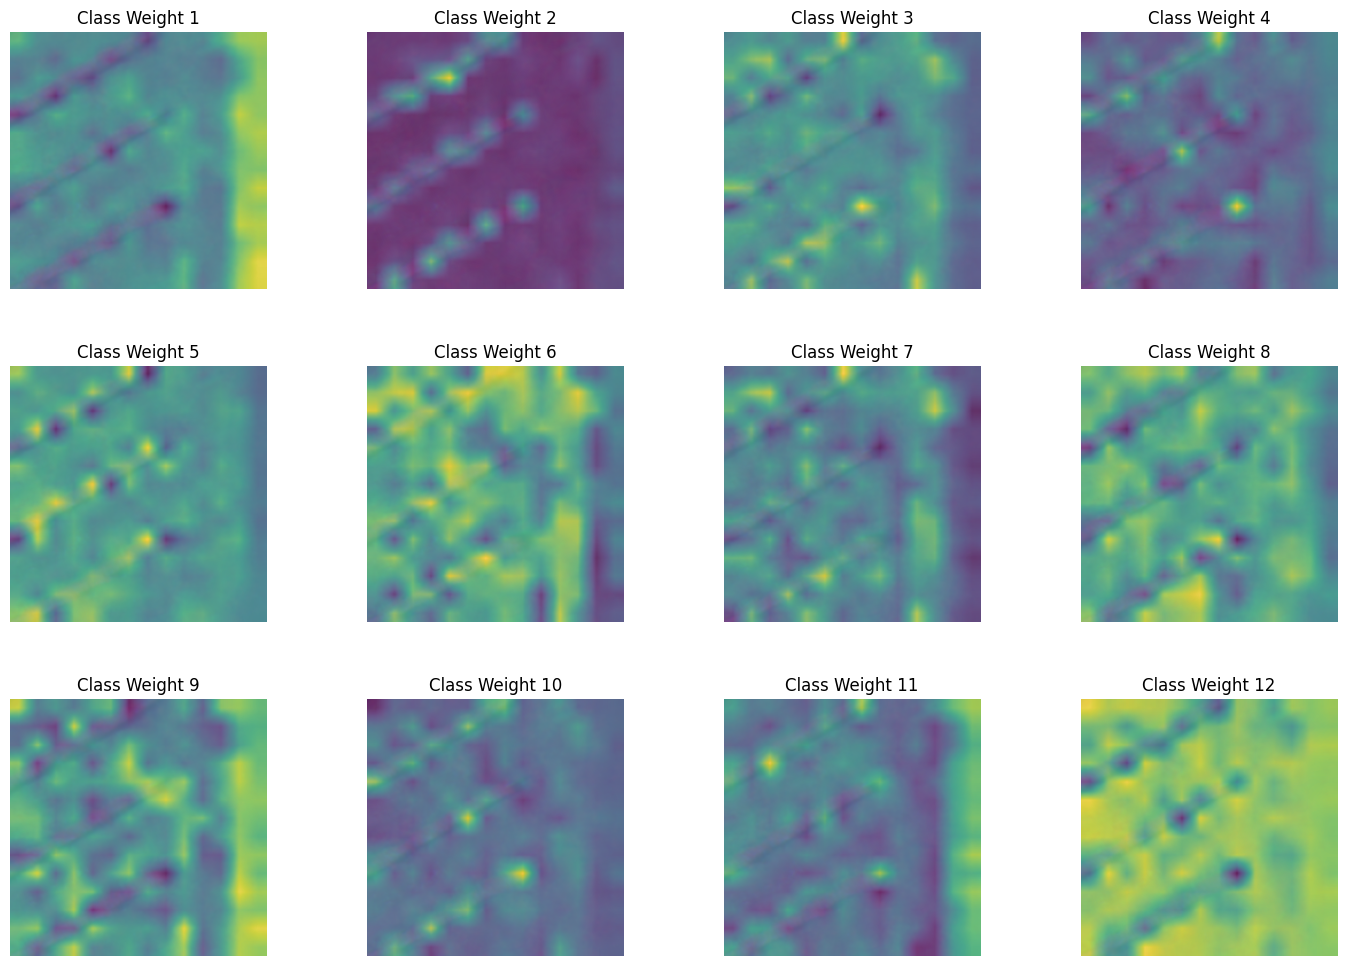

In [160]:
cls_weights_cpu = []
for i in range(12):
    cls_weight = cls_weights[i]
    cls_weight_cpu = cls_weight.cpu()
    cls_weights_cpu.append(cls_weight_cpu)
    
plot_cls_weights(cls_weights_cpu, img_resized[:,:,[3,1,0]])

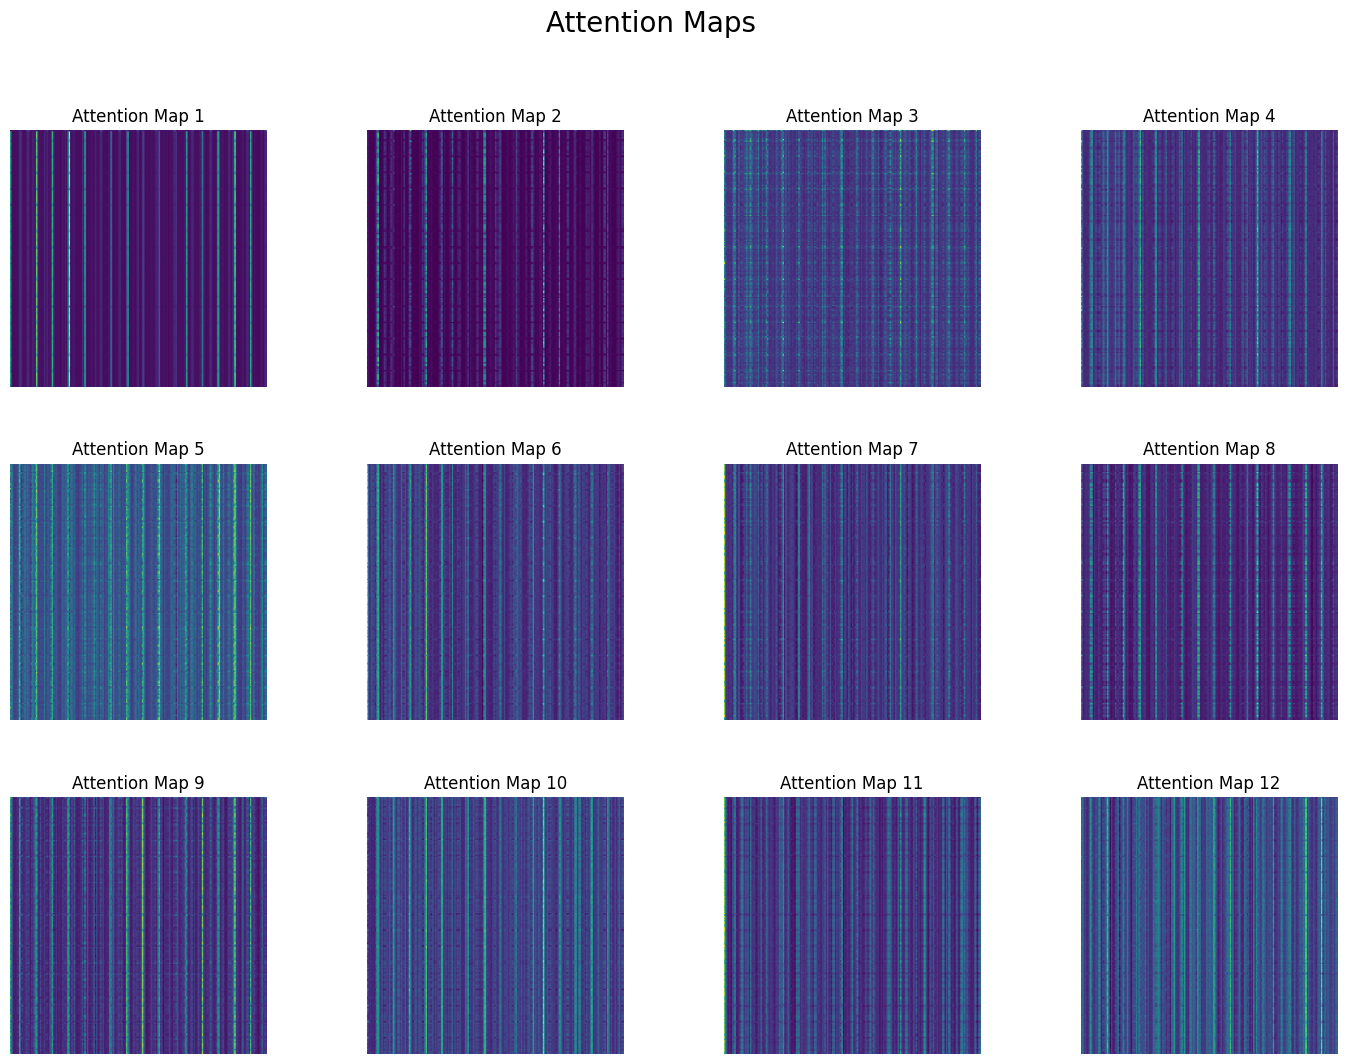

In [161]:
attn_maps_cpu = []
for i in range(12):
    attn_map = attn_maps[i]
    attn_map_cpu = attn_map.cpu()
    attn_maps_cpu.append(attn_map_cpu)
plot_attention_maps(attn_maps_cpu, num_cols=4)